In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [13]:
class Dolphin:
    def __init__(self, name: str, gender: str):
        self.name = name
        self.gender = gender

    def __str__(self):
        return f'Name: {self.name:<15} | Gender: {self.gender}'

In [14]:

# Build a dolphin dictionary
dolphins: list[Dolphin] = []
with open('data/dolphininfo.txt', 'r') as f:
    for idx, line in enumerate(f):
        name, gender = line.strip().split()
        new_dolphin = Dolphin(name,gender)
        dolphins.append(new_dolphin)

for i in range(5):
    print(dolphins[i])

Name: Beak            | Gender: M
Name: Beescratch      | Gender: M
Name: Bumper          | Gender: M
Name: CCL             | Gender: F
Name: Cross           | Gender: M


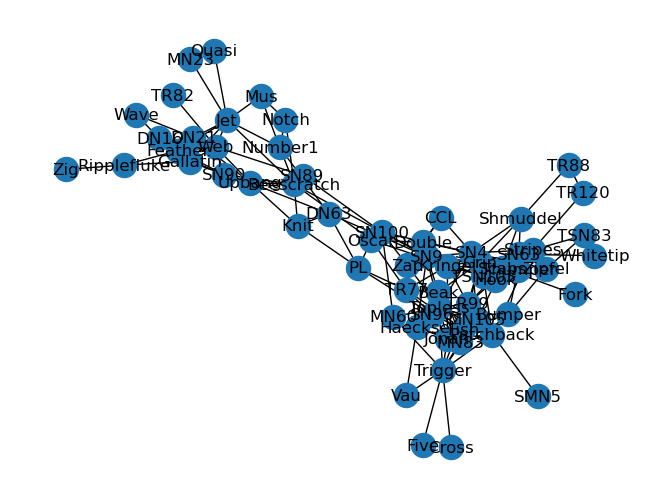

In [15]:
# Build a dolphines network
dolphin_graph = nx.Graph()

with open('data/dolphins.txt', 'r') as f:
    lines = f.readlines()
    
    no_nodes = int(lines[0])
    dolphin_graph.add_nodes_from([dolphins[i].name for i in range(no_nodes)])

    # dolphin_graph.add_edges_from([tuple(map(int, line.split())) for line in lines[1:]])
    for line in lines[1:]:
        startpoint, endpoint = map(lambda x: int(x)-1, line.split())
        dolphin_graph.add_edge(dolphins[startpoint].name, dolphins[endpoint].name)

# Draw the network
nx.draw(dolphin_graph, with_labels=True)


In [16]:

print(f'Grin degree: {dolphin_graph.degree("Grin")}')
print(f'Grin neighbors: {list(dolphin_graph.neighbors("Grin"))}')

dolphin_dict = {dolphin.name: dolphin.gender for dolphin in dolphins}


Grin degree: 12
Grin neighbors: ['Beak', 'CCL', 'Hook', 'MN83', 'Scabs', 'Shmuddel', 'SN4', 'SN63', 'SN9', 'Stripes', 'TR99', 'TSN103']


In [17]:
# Question a

# tested candidate set counter for both algorithms
tcs_basic_counter = 0
tcs_improved_counter = 0

class CliqueSet:
    def __init__(self, nodes: set[str], G: nx.Graph):
        self.nodes = nodes
        # Sort nodes to make the key distinct without considering the order
        # and make the output string more readable
        self.__sorted_nodes = sorted(nodes)
        self.fs = self.__calculate_fs(self.nodes, G)
    

    def should_add_node(self, v: str, G: nx.Graph, alpha: float) -> bool:
        '''
        Check if the current clique set could be extended by adding node v.
        '''
        new_nodes = self.nodes.union({v})
        fs = self.__calculate_fs(new_nodes, G)
        return not any(fs < self.__upper_bound(new_nodes, G, u, alpha) for u in new_nodes)


    def union(self, other: set[str], G: nx.graph) -> 'CliqueSet':
        '''
        Return a new CliqueSet by unioning the current set with another set.
        '''
        return CliqueSet(self.nodes.union(other), G)
    

    def __calculate_fs(self, nodes: set[str], G: nx.Graph) -> float:
        '''
        Return f(S) = min_{v in S} degree(v, S) / (|S| - 1)
        '''
        if len(nodes) == 1:
            return 1
        degrees_S_v = [len([u for u in G.neighbors(v) if u in nodes]) for v in nodes]
        return min(degrees_S_v) / (len(nodes) - 1)
    

    def __upper_bound(self, nodes: set[str], G: nx.Graph, v: str, alpha: float) -> float:
        return 1 - (G.degree[v] * (1-alpha)) / ((len(nodes) - 1) * alpha)
    

    def __key(self):
        return tuple(self.__sorted_nodes)


    def __hash__(self):
        return hash(self.__key())
    
    
    def __eq__(self, other):
        if isinstance(other, CliqueSet):
            return self.nodes == other.nodes
        return False
    
    
    def __lt__(self, other):
        if not isinstance(other, CliqueSet):
            return NotImplemented
        
        if len(self.nodes) == len(other.nodes):
            return self.__sorted_nodes < other.__sorted_nodes
        return len(self.__sorted_nodes) < len(other.__sorted_nodes)
    

    def __len__(self):
        return len(self.nodes)
    

    def __iter__(self):
        return iter(self.nodes)
    

    def __str__(self):
        return f'{str(self.__sorted_nodes):<70} | fs: {self.fs:.2f}'



def dfs(S: CliqueSet, G: nx.Graph, start: str, visited: set[str], cliques: set[CliqueSet],
        alpha: float) -> None:
    '''
    Recursive Depth-First-Search (DFS) to find alpha-clique sets.
    '''
    global tcs_basic_counter
    tcs_basic_counter += 1

    visited.add(start)
    if S.fs >= alpha:
        cliques.add(S)

    for v in G.neighbors(start):
        if v not in visited and S.should_add_node(v, G, alpha):
            new_S = S.union({v}, G)
            # new_candidates = G.neighbors(v)
            dfs(new_S, G, v, visited, cliques, alpha)


def dfs_improved(S: CliqueSet, G: nx.Graph, start: str, visited: set[str], cliques: set[CliqueSet],
        alpha: float) -> None:
    '''
    Recursive Depth-First-Search (DFS) to find alpha-clique sets.
    The upper bound is maximized to improve pruning effect.
    '''
    global tcs_improved_counter
    tcs_improved_counter += 1

    visited.add(start)
    if S.fs >= alpha:
        cliques.add(S)

    # Sort candidates by degree (ascending) to maximize pruning effect
    # The idea is to maximize the upper bound, which means maximize
    # 1 - (G.degree[v] * (1-alpha)) / ((len(S) - 1) * alpha)
    # equivalent to minimize (G.degree[v] * (1-alpha)) / ((len(S) - 1) * alpha)
    # equivalent to minimize G.degree[v]
    # equivalent to prioritize nodes with lower degree
    candidates = list(G.neighbors(start))
    sorted_candidates = sorted(candidates, key=lambda v: G.degree[v])

    for v in sorted_candidates:
        if v not in visited and S.should_add_node(v, G, alpha):
            new_S = S.union({v}, G)
            # new_candidates = G.neighbors(v)
            dfs_improved(new_S, G, v, visited, cliques, alpha)


def find_alpha_cliques(G: nx.Graph, alpha: float, adv_alg = False) -> list[set[str]]:
    '''
    Find all alpha-cliques in graph G.
    Using the improved DFS algorithm if adv_alg is True.
    Otherwise, using the basic DFS algorithm by default.
    '''
    cliques = set()
    if adv_alg:
        for v in G.nodes:
            visited = set()
            dfs_improved(CliqueSet({v}, G), G, v, visited, cliques, alpha)
    else:
        for v in G.nodes:
            visited = set()
            dfs(CliqueSet({v}, G), G, v, visited, cliques, alpha)

    return sorted(cliques, reverse=True)




In [18]:
alpha = 0.8

# Run the basic algorithm
cliques = find_alpha_cliques(dolphin_graph, alpha)
print(f'Number of tested candidate sets: {tcs_basic_counter}')
print(f'Number of {alpha}-cliques: {len(cliques)}')
for clique in cliques:
    print(clique)

Number of tested candidate sets: 621
Number of 0.8-cliques: 201
['Grin', 'Hook', 'SN4', 'SN63', 'Scabs', 'Stripes']                    | fs: 0.80
['DN21', 'Feather', 'Gallatin', 'Jet', 'Web']                          | fs: 1.00
['Jonah', 'MN105', 'Patchback', 'Trigger']                             | fs: 1.00
['Grin', 'SN4', 'Scabs', 'Shmuddel']                                   | fs: 1.00
['Grin', 'Hook', 'Scabs', 'TR99']                                      | fs: 1.00
['Grin', 'Hook', 'SN63', 'Scabs']                                      | fs: 1.00
['Grin', 'Hook', 'SN4', 'Scabs']                                       | fs: 1.00
['DN21', 'Feather', 'Gallatin', 'Jet']                                 | fs: 1.00
['DN16', 'Feather', 'Gallatin', 'Web']                                 | fs: 1.00
['Beak', 'Fish', 'SN96', 'TR77']                                       | fs: 1.00
['MN83', 'Patchback', 'Topless']                                       | fs: 1.00
['MN60', 'Topless', 'Trigger']    

In [19]:
# Run the improved algorithm
cliques_improved = find_alpha_cliques(dolphin_graph, alpha, adv_alg=True)
print(f'Number of tested candidate sets (improved): {tcs_improved_counter}')
print(f'Number of {alpha}-cliques (improved): {len(cliques_improved)}')
for clique in cliques_improved:
    print(clique)

Number of tested candidate sets (improved): 574
Number of 0.8-cliques (improved): 201
['Jonah', 'MN105', 'MN83', 'Patchback', 'Topless', 'Trigger']          | fs: 0.80
['Grin', 'Hook', 'SN4', 'SN63', 'Scabs', 'Stripes']                    | fs: 0.80
['DN21', 'Feather', 'Gallatin', 'SN90', 'Upbang', 'Web']               | fs: 0.80
['DN21', 'Feather', 'Gallatin', 'Jet', 'Web']                          | fs: 1.00
['DN21', 'Feather', 'Gallatin', 'Jet']                                 | fs: 1.00
['DN16', 'Feather', 'Gallatin', 'Web']                                 | fs: 1.00
['Beak', 'Fish', 'SN96', 'TR77']                                       | fs: 1.00
['SN4', 'Scabs', 'Shmuddel']                                           | fs: 1.00
['SN100', 'SN4', 'SN9']                                                | fs: 1.00
['Oscar', 'PL', 'TR77']                                                | fs: 1.00
['Mus', 'Notch', 'Number1']                                            | fs: 1.00
['MN60', 'To

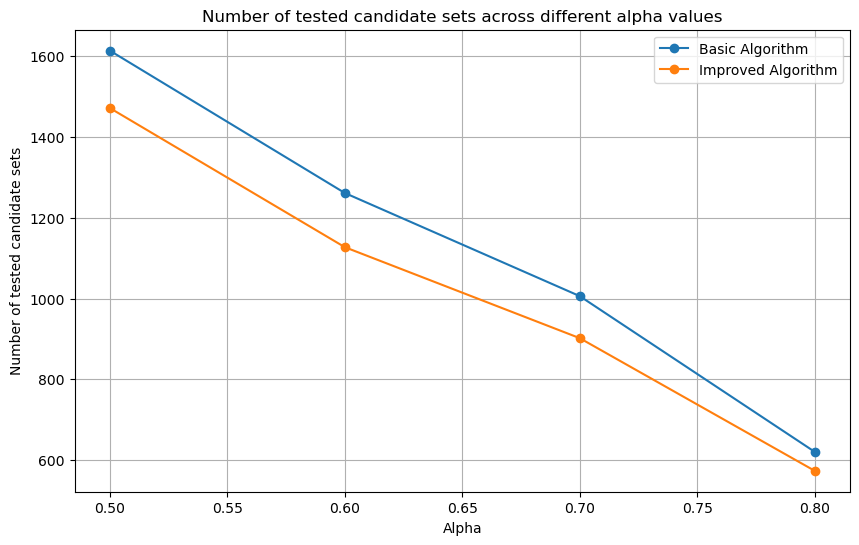

In [20]:
### Question b

alphas = [0.5, 0.6, 0.7, 0.8]
tcs_basic_counters = []
tcs_improved_counters = []

for alpha in alphas:
    tcs_basic_counter = 0
    cliques = find_alpha_cliques(dolphin_graph, alpha)
    tcs_basic_counters.append(tcs_basic_counter)
    
    tcs_improved_counter = 0
    cliques_improved = find_alpha_cliques(dolphin_graph, alpha, adv_alg=True)
    tcs_improved_counters.append(tcs_improved_counter)


# Plot the number of tested candidate sets across different alpha values
# for both basic and improved algorithms
plt.figure(figsize=(10, 6))
plt.plot(alphas, tcs_basic_counters, '-o', label='Basic Algorithm')
plt.plot(alphas, tcs_improved_counters, '-o', label='Improved Algorithm')
plt.xlabel('Alpha')
plt.ylabel('Number of tested candidate sets')
plt.title('Number of tested candidate sets across different alpha values')
plt.legend()
plt.grid()
plt.show()
    

In [21]:
# Question c
# Search the maximal alpha-cliques when alpha = 0.8 and the set size is at least 5
alpha = 0.8
min_set_size = 5

cliques_improved = find_alpha_cliques(dolphin_graph, alpha, adv_alg=True)
maximal_cliques = [clique for clique in cliques_improved if len(clique) >= min_set_size]
for i, cli in enumerate(maximal_cliques, start=1):
    print(f'{i}: {cli}')

1: ['Jonah', 'MN105', 'MN83', 'Patchback', 'Topless', 'Trigger']          | fs: 0.80
2: ['Grin', 'Hook', 'SN4', 'SN63', 'Scabs', 'Stripes']                    | fs: 0.80
3: ['DN21', 'Feather', 'Gallatin', 'SN90', 'Upbang', 'Web']               | fs: 0.80
4: ['DN21', 'Feather', 'Gallatin', 'Jet', 'Web']                          | fs: 1.00


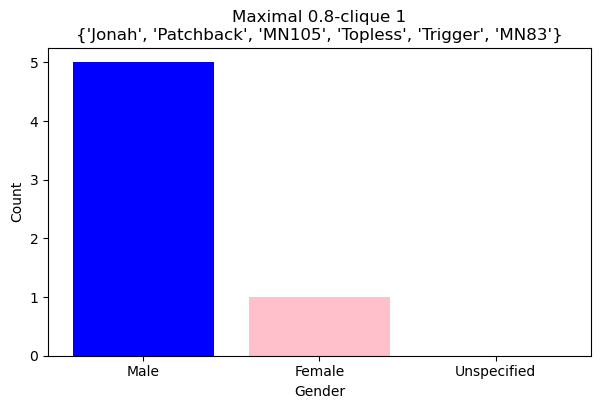

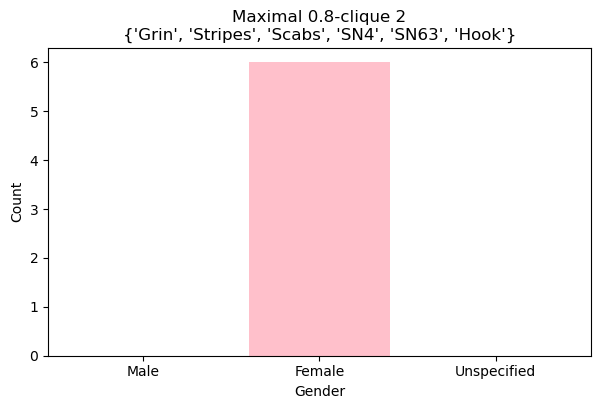

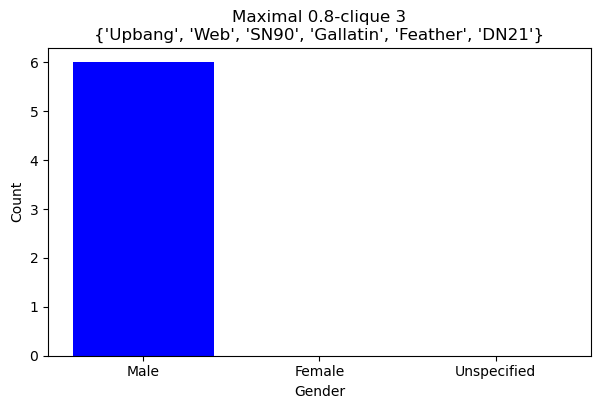

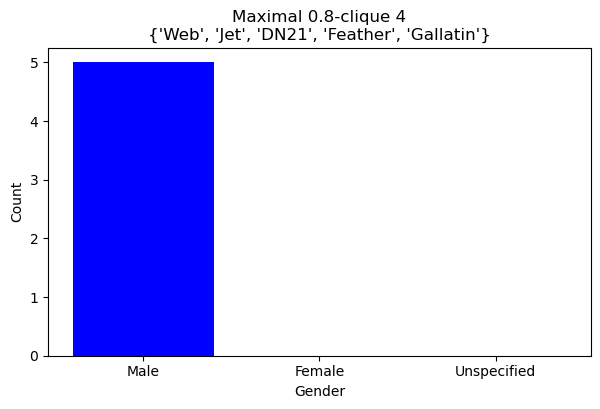

In [22]:
# Investigate the gender distribution of the maximal alpha-cliques
clique_gender_distribution = []
for clique in maximal_cliques:
    gender_count = {gender: 0 for gender in set(dolphin_dict.values())}
    for dolphin in clique:
        gender_count[dolphin_dict[dolphin]] += 1
    clique_gender_distribution.append(gender_count)

for i, gender_count in enumerate(clique_gender_distribution, start=1):
    labels = ['Male', 'Female', 'Unspecified']
    values = [gender_count['M'], gender_count['F'], gender_count['U']]

    clique = maximal_cliques[i-1].nodes

    # Bar chart
    plt.figure(figsize=(7, 4))
    plt.bar(labels, values, color=['blue', 'pink', 'grey'])
    plt.title(f"Maximal {alpha}-clique {i}\n{clique}")
    plt.ylabel("Count")
    plt.xlabel("Gender")
    plt.show()